In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

tesla_data = pd.read_csv("historical stock data/tesla_data.csv")


In [197]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [199]:
tesla_data.isnull().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [201]:
# Reverse the rows
tesla_data = tesla_data.iloc[::-1].reset_index(drop=True)
#reading the date column by converting to date time format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

In [203]:
# Columns to be cleaned
columns_to_clean = ['Open', 'Close/Last', 'High', 'Low']

# Remove dollar signs and convert to numeric for each specified column
for column in columns_to_clean:
    tesla_data[column] = tesla_data[column].astype(str).str.replace('[$,]', '', regex=True)
    tesla_data[column] = pd.to_numeric(tesla_data[column], errors='coerce')
tesla_data.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-07-11,14.5420,49491275,14.7073,14.7733,14.5067
2014-07-14,15.1133,107969721,14.6660,15.2527,14.3634
2014-07-15,14.6387,85719122,15.1153,15.1767,14.5400
2014-07-16,14.4773,60625005,14.7880,14.9867,14.4547
2014-07-17,14.3600,69712720,14.4107,14.7033,14.2400


In [205]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
tesla_scaled = tesla_data.copy()
columns = ['Close/Last','Volume','Open','High','Low']
tesla_scaled[columns] = scaler.fit_transform(tesla_data[columns])
tesla_scaled.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-07-11,0.012398,0.042989,0.012984,0.010991,0.012879
2014-07-14,0.013825,0.107718,0.012881,0.012177,0.012517
2014-07-15,0.012639,0.083089,0.013999,0.011989,0.012963
2014-07-16,0.012236,0.055313,0.013185,0.011519,0.012748
2014-07-17,0.011943,0.065372,0.012246,0.010817,0.012206


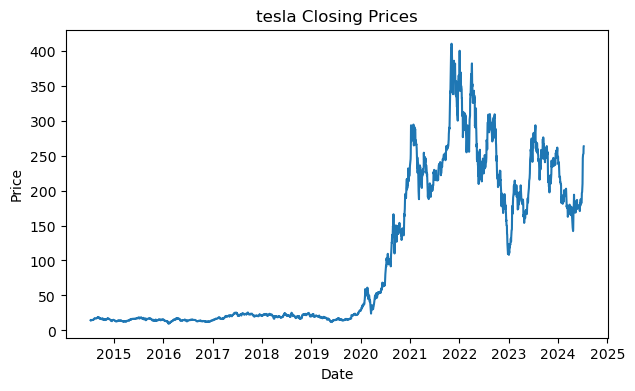

In [207]:
# Plot the closing prices
plt.figure(figsize=(7, 4))
plt.plot(tesla_data['Close/Last'])
plt.title('tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

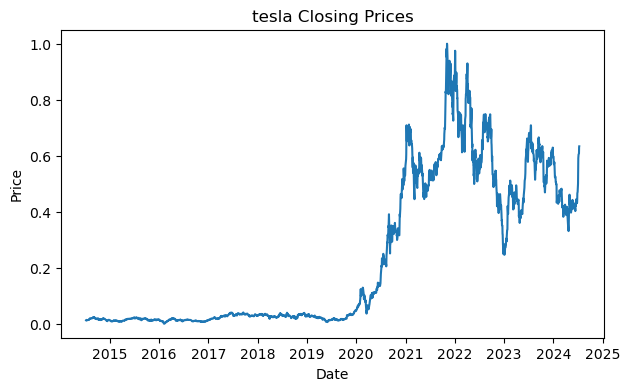

In [208]:
# Plot the closing prices
plt.figure(figsize=(7, 4))
plt.plot(tesla_scaled['Close/Last'])
plt.title('tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

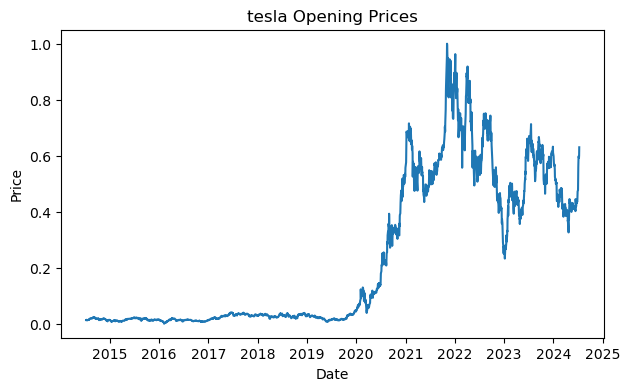

In [210]:
# Plot the closing prices
plt.figure(figsize=(7, 4))
plt.plot(tesla_scaled['Open'])
plt.title('tesla Opening Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

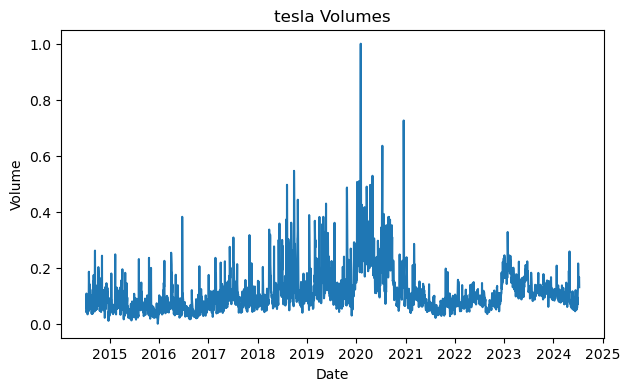

In [211]:
# Plot the closing prices
plt.figure(figsize=(7, 4))
plt.plot(tesla_scaled['Volume'])
plt.title('tesla Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [215]:
tesla_data.corr()

,Close/Last,Volume,Open,High,Low
Close/Last,1.000000,-0.049430,0.999043,0.999444,0.999614
Volume,-0.049430,1.000000,-0.050789,-0.045559,-0.055307
Open,0.999043,-0.050789,1.000000,0.999538,0.999543
High,0.999444,-0.045559,0.999538,1.000000,0.999403
Low,0.999614,-0.055307,0.999543,0.999403,1.000000


<Figure size 1400x700 with 0 Axes>

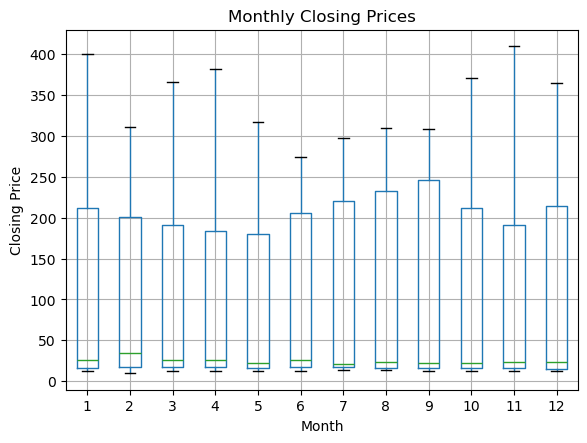

In [217]:
tesla_data['Month'] = tesla_data.index.month
plt.figure(figsize=(14, 7))
tesla_data.boxplot(column='Close/Last', by='Month')
plt.title('Monthly Closing Prices')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.show()

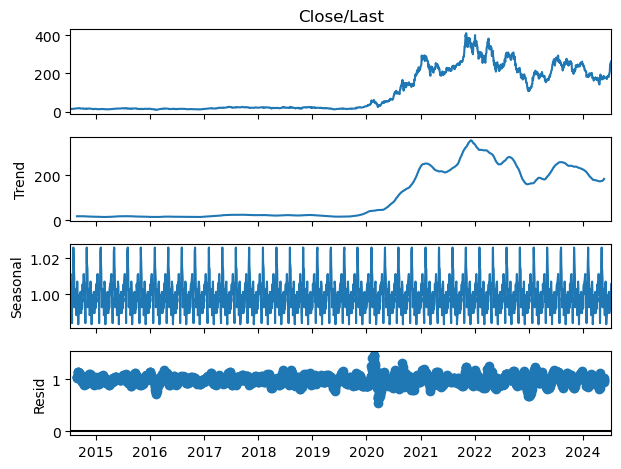

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tesla_data['Close/Last'], model='multiplicative', period=63)  # Assuming 252 trading days in a year

result.plot()
plt.show()

In [219]:
tesla_data.drop(columns=['Volume', 'Open','High','Low','Month'], inplace=True)

In [221]:
# Define training data length about 80 percent train data
training_data_len = 2016

# Split the data
train_data = tesla_data[0:training_data_len]
test_data = tesla_data[training_data_len:]


In [222]:
train_data

,Close/Last
Date,
2014-07-11,14.5420
2014-07-14,15.1133
2014-07-15,14.6387
2014-07-16,14.4773
2014-07-17,14.3600
...,...
2022-07-07,244.5433
2022-07-08,250.7633
2022-07-11,234.3433


In [223]:
# Ensure train_data and test_data are numpy arrays
train_data = train_data.values
test_data = test_data.values

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 63
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [224]:
len(X_train)

1953

In [225]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [226]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - loss: 7578.8174
Epoch 2/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - loss: 736.5521
Epoch 3/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 579.4257
Epoch 4/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - loss: 451.5311
Epoch 5/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 229.8365
Epoch 6/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 188.9208
Epoch 7/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 130.2659
Epoch 8/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - loss: 105.3410
Epoch 9/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - loss: 146.3130
Epoch 10/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 120s 61ms/step - loss: 93.4138


In [252]:
# Make predictions
predictions = model.predict(X_test)

# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len + seq_length:]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [253]:
# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len + seq_length:].values
# Adjust the valid DataFrame to match the length of predictions
valid = tesla_data[training_data_len + seq_length:].copy()
valid['Predictions'] = predictions
valid

,Close/Last,Predictions
Date,,
2022-10-12,217.24,245.254913
2022-10-13,221.72,244.931747
2022-10-14,204.99,245.778915
2022-10-17,219.35,241.552307
2022-10-18,220.19,244.518631
...,...,...
2024-07-03,246.39,245.910294
2024-07-05,251.52,249.145569
2024-07-08,252.94,250.740097


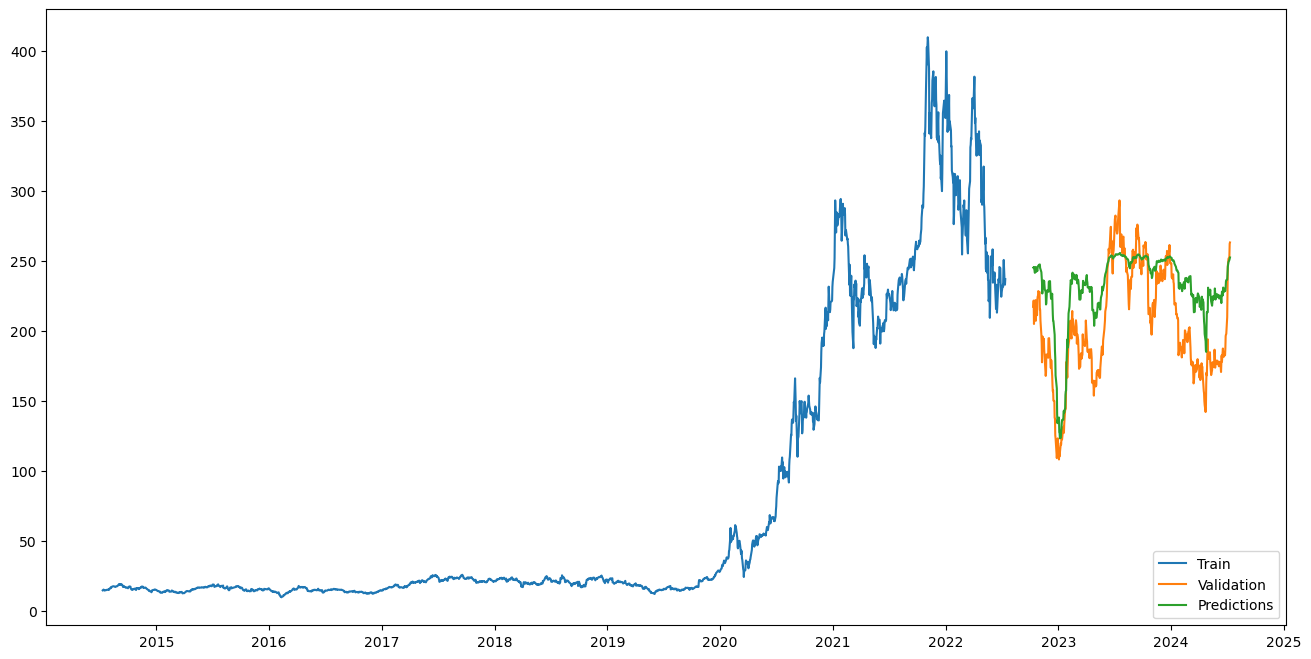

In [261]:
# Plot the results
train = tesla_data[:training_data_len]

plt.figure(figsize=(16,8))
plt.plot(train['Close/Last'], label='Train')
plt.plot(valid[['Close/Last']], label='Validation')
plt.plot(valid[['Predictions']], label='Predictions') 
plt.legend(loc='lower right')
plt.show()

In [263]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming `actual_prices` and `predictions` are your actual and predicted values
mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_prices, predictions)

# Print all metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Squared Error (MSE): 1231.816147719868
Mean Absolute Error (MAE): 30.303022732592833
Mean Absolute Percentage Error (MAPE): 25.13%


In [265]:
tesla_data.sample(10)

,Close/Last
Date,
2016-10-18,13.2733
2021-09-10,245.4233
2018-05-18,18.4547
2024-06-18,184.8600
2022-04-21,336.2600
2017-04-13,20.2667
2022-03-28,363.9466
2018-01-10,22.3200
2024-03-01,202.6400


In [269]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 57s 26ms/step - loss: 7130.2466
Epoch 2/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - loss: 706.4155
Epoch 3/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 511.9734
Epoch 4/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 383.1769
Epoch 5/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - loss: 347.5431
Epoch 6/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 363.1956
Epoch 7/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 300.9720
Epoch 8/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - loss: 319.6751
Epoch 9/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - loss: 638.1982
Epoch 10/10
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 572.6567


In [270]:
# Make predictions
predictions = model.predict(X_test)

# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len + seq_length:]

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [273]:
# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len + seq_length:].values
# Adjust the valid DataFrame to match the length of predictions
valid = tesla_data[training_data_len + seq_length:].copy()
valid['Predictions'] = predictions
valid

,Close/Last,Predictions
Date,,
2022-10-12,217.24,233.232315
2022-10-13,221.72,232.259537
2022-10-14,204.99,233.248184
2022-10-17,219.35,229.382889
2022-10-18,220.19,231.099609
...,...,...
2024-07-03,246.39,232.178085
2024-07-05,251.52,241.540131
2024-07-08,252.94,247.189133


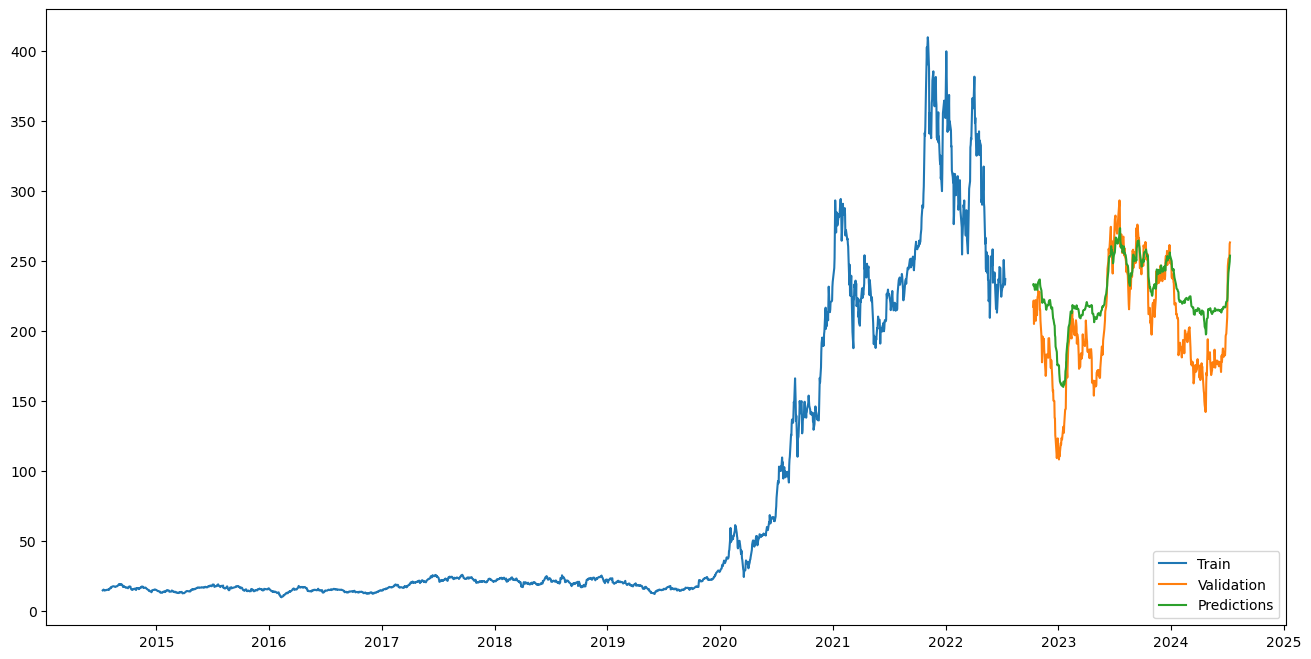

In [275]:
# Plot the results
train = tesla_data[:training_data_len]

plt.figure(figsize=(16,8))
plt.plot(train['Close/Last'], label='Train')
plt.plot(valid[['Close/Last']], label='Validation')
plt.plot(valid[['Predictions']], label='Predictions') 
plt.legend(loc='lower right')
plt.show()

In [276]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming `actual_prices` and `predictions` are your actual and predicted values
mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_prices, predictions)

# Print all metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Squared Error (MSE): 854.5988886964316
Mean Absolute Error (MAE): 24.048442509910885
Mean Absolute Percentage Error (MAPE): 22.79%


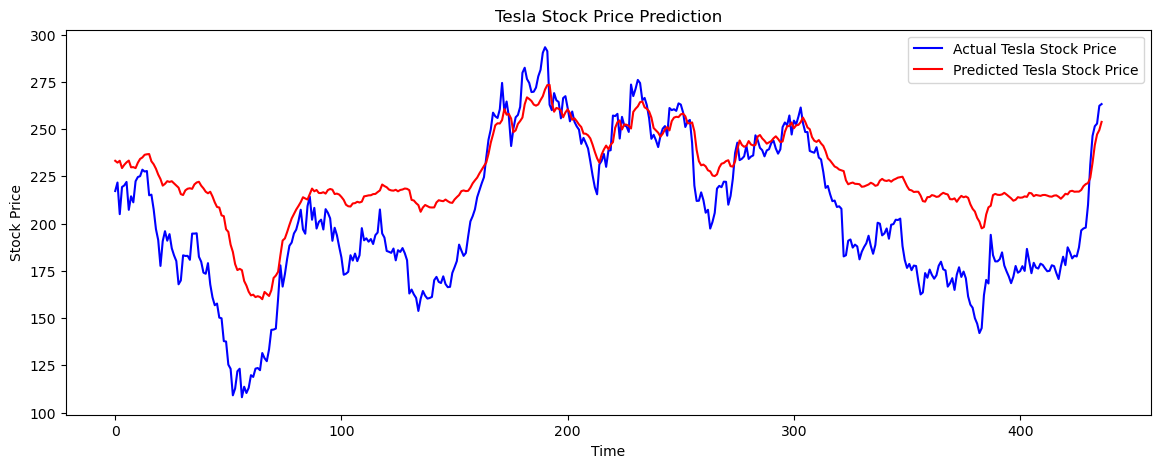

In [280]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
